In [29]:
import numpy as np
from numpy import zeros, eye, diag, exp, log
from numpy.linalg import norm, solve
from numpy.random import randn, rand
from scipy.stats import multivariate_normal as MVN
from scipy.stats import uniform as udist
from itertools import product

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from utils import prep_contour, generate_powers_of_ten

from warnings import catch_warnings, filterwarnings

In [2]:
# Manifold
μ       = zeros(2)
Σ       = diag([1, 0.1])
target  = MVN(μ, Σ)
f = target.logpdf
z0      = -2.9513586307684885                # Specifies exactly which ellipse we are interested in (y*).
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

# Gradient function
grad  = lambda xi: -solve(Σ, xi - μ)
q = MVN(zeros(2), eye(2))

# Prior function is uniform on a huge square
square_side = 10  # SQUARE SIDE
logprior  = lambda xi: udist.logpdf(xi, loc=-square_side, scale=2*square_side).sum()

In [3]:
# fig, ax = plt.subplots(figsize=(5,5))
# ax.contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, target.logpdf), levels=[z0])
# ax.set_aspect("equal")
# plt.show()

In [15]:
def HugTangential(x0, δ, B, N, α, q, logpi, grad_log_pi):
    """
    Repurposed version of THUG.
    """
    # The following dictionary stores everything we need
    OUT = {
#         'D' : {f"{i}": [] for i in range(N)}, # Distance
#         'SD': {f"{i}": [] for i in range(N)}, # Square Distance
        'AR': [np.nan for i in range(N)],     # Acceptance Ratio
        'KE': [np.nan for i in range(N)],     # Kinetic Energy
#         'SAMPLES': x0,
        'ACCEPTANCES': np.zeros(N),
#         'EJSD': [np.nan for i in range(N)],    # Acceptance Ratio * Squared Distance
        'EJSD_AP': [np.nan for i in range(N)]    # Acceptance PROBABILITY * Squared Distance
    }
    for i in range(N):
        v0s = q.rvs()                    # Draw velocity spherically
        g = grad_log_pi(x0)              # Compute gradient at x0
        g = g / norm(g)                  # Normalize
        v0 = v0s - α * g * (g @ v0s) # Tilt velocity
        v, x = v0, x0                    # Housekeeping
        logu = np.log(rand())            # Acceptance ratio
        for _ in range(B):
            xmid = x + δ*v/2           # Move to midpoint
            g = grad_log_pi(xmid)          # Compute gradient at midpoint
            ghat = g / norm(g)          # Normalize 
            v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
            x = xmid + δ*v/2           # Move from midpoint to end-point
            # Compute metrics
#             OUT['D'][f"{i}"].append(norm(x - x0))
#             OUT['SD'][f"{i}"].append(norm(x  -x0)**2)

        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (α / (1 - α)) * g * (g @ v)
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        logar = logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s)
        ar = exp(logar)
        OUT['AR'][i] = ar
        OUT['KE'][i] = norm(v)**2 - norm(v0s)**2
#         OUT['EJSD'][i] = ar * (norm(x - x0)**2)
        OUT['EJSD_AP'][i] = np.clip(ar, a_min=0.0, a_max=1.0) * (norm(x - x0)**2)
        if logu <= logar:
#             OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x))
            OUT['ACCEPTANCES'][i] = 1         # Accepted!
            x0 = x
        else:
#             OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x0))
            OUT['ACCEPTANCES'][i] = 0         # Rejected
    return OUT

In [ ]:
# Settings
# ϵ = 0.00001
# n_grid = 30

def generate_logpi(ϵ):
    # Kernel
    def logkernel(xi):
        with np.errstate(divide='ignore'):
            return log(float(norm(f(xi) - z0) < ϵ) / ϵ)
    # Logpi
    #logpi = lambda xi: logprior(xi) + logkernel(xi)
    logpi = lambda xi: logkernel(xi)
    return logpi

In [17]:
# msd = lambda out: np.vstack([out['SD'][f"{i}"] for i in range(N)]).mean(axis=0)

In [18]:
# αs = np.linspace(0.0, 1.0, num=n_grid, endpoint=False)
# δs = np.logspace(-3, 0, num=n_grid, endpoint=True)
# ϵs = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [19]:
# EJSD_GRID = np.zeros((len(ϵs), len(αs), len(δs)))
# for ϵix, ϵ in enumerate(ϵs):
#     for αix, α in enumerate(αs):
#         for δix, δ in enumerate(δs):
#             x0 = ellipse.sample()
#             logpi = generate_logpi(ϵ)
#             EJSD_GRID[ϵix, αix, δix] = np.mean(HugTangential(x0, δ, B, N, α, q, logpi, grad)['EJSD'])

In [20]:
# EJSD_GRID_AP = np.zeros((len(ϵs), len(αs), len(δs)))
# for ϵix, ϵ in enumerate(ϵs):
#     for αix, α in enumerate(αs):
#         for δix, δ in enumerate(δs):
#             x0 = ellipse.sample()
#             logpi = generate_logpi(ϵ)
#             EJSD_GRID_AP[ϵix, αix, δix] = np.mean(HugTangential(x0, δ, B, N, α, q, logpi, grad)['EJSD_AP'])

In [21]:
# from matplotlib.colors import LogNorm
# from matplotlib.ticker import LogFormatterMathtext

In [22]:
# fig = plt.figure(figsize=(18, 5))

# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(1,5),
#                  axes_pad=0.2,
#                  share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.2,
#                  )
# # Add data to image grid
# for i, ax in enumerate(grid):
#     im = ax.imshow(EJSD_GRID[i, :, :], origin='lower', extent=[0.001, 1.0, 0.0, 1.0], norm=LogNorm())
#     ax.set_xscale('log')
#     # X axis
#     ax.set_xticks(δs[::4]) #np.arange(0, 30, 4))
#     ax.set_xticklabels(["{:.2f}".format(δ) for δ in δs[::4]], fontsize=8)
#     ax.set_xlabel(r"$\mathregular{\delta}$", fontname='STIXGeneral', fontsize=15)
#     # Y axis
#     ax.set_yticks(αs[::4]) #np.arange(0, 30, 4))
#     ax.set_yticklabels(["{:.1f}".format(α) for α in αs[::4]], fontsize=8)
#     ax.set_ylabel(r"$\mathregular{\alpha}$", fontname='STIXGeneral', fontsize=15)
#     ax.set_title(r"$\mathregular{\epsilon}=$" + r"{}".format(ϵs[i]), fontsize=15, fontname='STIXGeneral')
#     ax.set_aspect('auto')
# ax.cax.colorbar(im, format=LogFormatterMathtext())
# ax.cax.toggle_label(True)
# plt.show()

In [28]:
def generate_grid(ϵs, αs, δs, x0s):
    EJSD_GRID_AP = np.zeros((len(ϵs), len(αs), len(δs)))
    for ϵix, ϵ in enumerate(ϵs):
        for αix, α in enumerate(αs):
            for δix, δ in enumerate(δs):
                logpi = generate_logpi(ϵ)
                EJSD_GRID_AP[ϵix, αix, δix] = np.mean(HugTangential(x0s[ϵix], δ, B, N, α, q, logpi, grad)['EJSD_AP'])
    return EJSD_GRID_AP
##### SUPER IMPORTANT: EJSD --> EJSD_AP!!!

In [24]:
##### SUPER IMPORTANT: EJSD --> EJSD_AP!!!
# ϵs = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001])
# αs = np.geomspace(1, 2, num=n_grid, endpoint=False) - 1
# δs = np.geomspace(0.001, 10.0, num=n_grid, endpoint=False)
# EJSD_GRID_LOG = generate_grid(
#     ϵs = ϵs,
#     αs = αs,
#     δs = δs
# )

In [25]:
# ##### SUPER IMPORTANT: EJSD --> EJSD_AP!!!
# αs_log = np.geomspace(1, 2, num=10, endpoint=False) - 1
# δs_log = np.geomspace(0.001, 10.0, num=10, endpoint=False)

# fig = plt.figure(figsize=(18, 5))

# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(1,5),
#                  axes_pad=0.2,
#                  share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.2,
#                  )
# # Add data to image grid
# for i, ax in enumerate(grid):
#     im = ax.imshow(EJSD_GRID_LOG[i, :, :], origin='lower')
#     # X axis
#     ax.set_xticks(δs_log[::4]) #np.arange(0, 30, 4))
#     ax.set_xticklabels(["{:.2f}".format(δ) for δ in δs_log[::4]], fontsize=8)
#     ax.set_xlabel(r"$\mathregular{\delta}$", fontname='STIXGeneral', fontsize=15)
#     ax.set_xscale('log')
#     # Y axis
#     ax.set_yticks(αs_log[::4]) #np.arange(0, 30, 4)
#     ax.set_yticklabels(["{:.1f}".format(α) for α in αs_log[::4]], fontsize=8)
#     ax.set_ylabel(r"$\mathregular{\alpha}$", fontname='STIXGeneral', fontsize=15)
#     ax.set_title(r"$\mathregular{\epsilon}=$" + r"{}".format(ϵs[i]), fontsize=15, fontname='STIXGeneral')
#     ax.set_yscale('log')
# ax.cax.colorbar(im)
# ax.cax.toggle_label(True)
# plt.show()

In [26]:
# αs_log = np.geomspace(1, 2, num=10, endpoint=False) - 1
# δs_log = np.geomspace(0.001, 10.0, num=10, endpoint=False)
# δ_grid_log, α_grid_log = np.meshgrid(δs_log, αs_log)

# fig, ax = plt.subplots(ncols=5, figsize=(20, 4))

# for i in range(5):
#     im = ax[i].pcolor(δ_grid_log, α_grid_log, EJSD_GRID_LOG[i, :, :])
#     ax[i].set_xscale('log')
#     ax[i].set_yscale('log')
# plt.colorbar(im)
# plt.show()

In [55]:
def generate_starting_points(ϵs, n_tries=10):
    x0s = np.zeros((len(ϵs), len(μ)))
    for i in range(len(ϵs)):
        j = 0
        while j <= n_tries:
            j += 1
            with catch_warnings():
                filterwarnings('error')
                try: 
                    x0 = ellipse.sample(advanced=True)
                    x0s[i, :] = x0
                    break
                except RuntimeWarning:
                    print(f"Can't find {i}th point. Trying again.")
                    continue
            if j == n_tries:
                raise ValueError("Couldn't find point.")
    return x0s

In [58]:
# Sampling Settings
B = 10       # Number of bounces per trajectory
N = 1000     # Number of samples

# Grid settings
n_grid = 20  # Grid size for αs and δs
ϵs = generate_powers_of_ten(-1, -6)
αs = np.linspace(start=0.0, stop=1.0, num=n_grid, endpoint=False)
δs = np.geomspace(start=0.001, stop=10.0, num=n_grid, endpoint=True)

# Starting points (one per ϵ)
x0s = generate_starting_points(ϵs)

In [59]:
EJSD_GRID = generate_grid(
    ϵs = ϵs,
    αs = αs,
    δs = δs,
    x0s = x0s
)

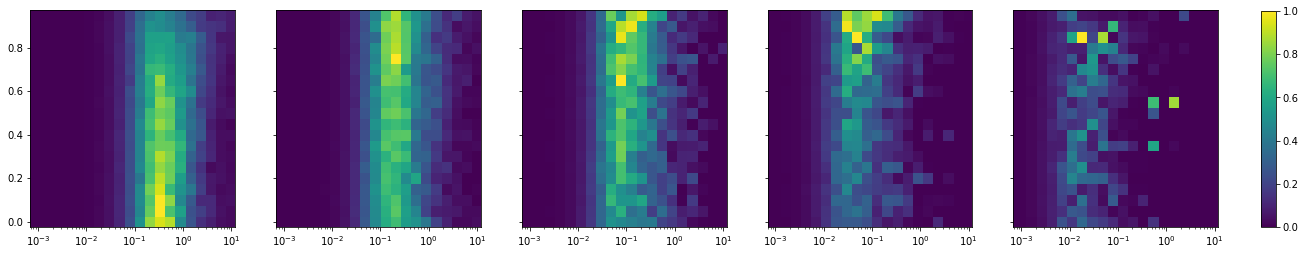

In [60]:
δ_grid, α_grid = np.meshgrid(δs, αs)
normalize = lambda a: a / np.nanmax(a)
fig, ax = plt.subplots(ncols=5, figsize=(20, 4), sharey=True, sharex=True)

for i in range(5):
    im = ax[i].pcolor(δ_grid, α_grid, normalize(EJSD_GRID[i, :, :]))
    ax[i].set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()